<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab02_spectrogram/MelSpectrogram.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a> 
# The Mel Spectrogram
## A Spectrogram on an AUDITORY FREQUENCY SCALE

In [ ]:
# uncomment the pip install command to install pyspch -- it is required!
#
#!pip install git+https://github.com/compi1234/pyspch.git
#
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
# Do the imports #
##################
#
%matplotlib inline
import os,sys 
import numpy as np
import pandas as pd
from IPython.display import display, Audio, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, Layout, HBox, VBox
#   
import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd
import matplotlib.pyplot as plt
import matplotlib as mpl
# import mel scale functions
from pyspch.sp.mel import *

mpl.rcParams["figure.figsize"] = (16,7)


SAVE_FIG = False

## 1. Computing the MEL Spectrogram

#### mel scale
A write-up on the mel-scale can be found in the companion notebook **Mel_scale.ipynb** in this folder.

The mel scale provides a mapping between Hz and mel and is an estimate of the non linear frequency axis of human hearing.
There is not such a thing as **the mel scale** written in stone as any formula is **estimated** on te basis human physiology and perception. There are a number of almost equivalent transformation in use in the speech community.  Our software uses the librosa default which is the same as the 'Slaney' mapping shown below.  Conceptually it is fine to think as follows about the mel scale is: *linear below 1kHz, logarithmic above it*.


#### mel filterbank  
A **mel filterbank** constitutes a set of filters that have the same shape and that are equally spaced on the mel scale.  By using a **mel filterbank** we can transform a Fourier spectrum into a **mel spectrum**.
The Hz-to-mel scale is only one aspect of the design such filterbank.  We also need to specify the number of filters that we want to use, alternatively said we need to define the resolution we want in mel scale.   Note that a filter in a mel filterbank is not a traditional filter.  It constitutes a set of interpolation weights over the power spectrum.

#### GUI for mel computations and variable number of mel coefficients
In the next cell you load an example waveform.  It is recommended to use both male and female voices
as some mel filterbank effects may differ between low and high pitched voices.   

The next cell is a GUI that demonstrates how mel scale computation exactly works
and it lets you can experiment with different numbers of filterbanks to see what the effect is on the mel spectrum. The steps in the computation are:
1. Computation of a Fourier Spectrogram
2. The usage of a mel filterbank to scale the frequency axis
   + the mel filterbank results in a spectrogram with unequal sampling on the frequency axis
   + for the mel spectrogram we plot the values against the mel coefficient index

In [3]:
# choose between a male and female demo file as some effects may differ between low and high pitched voices
# wavfile = "demo/timit_m1_sa1.wav"
wavfile = "demo/timit_f1_sa1.wav"
#wavfile = "demo/friendly.wav"
wavdata, sr = Spch.load_data(wavfile)
shift = 0.01
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
(nparam,nfr) = spg.shape

In [5]:
if sr <12000 :  
    (n_mels, fmin, fmax) = (20, 50., 4000.)
else:
    (n_mels, fmin, fmax) = (24, 50., 6500.)
    
def mel_slice_plot(iframe = 10,n_mels=24):
    spg_mel = Sps.spg2mel(spg,sample_rate=sr,n_mels=n_mels)
    freqs, fbank = mel_filterbank(n_mels=n_mels,sr=sr,fmin=fmin,fmax=fmax)
    
    fig_spg = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[spg_mel],sample_rate=sr,figsize=(12,4))
    fig_spg.add_vrect(iframe*shift,(iframe+1)*shift,iax=1)
    fig_spg.add_vrect(iframe*shift,(iframe+1)*shift,iax=2)
    fig_spg.axes[2].set_ylabel("mel coeff")
    display(fig_spg)
    
    freqax = np.linspace(0,sr/2,spg.shape[0])
    fig,ax = plt.subplots(4,1,figsize=(12,8))
    ax[0].plot(freqax,spg[:,iframe])
    ax[0].set_xlim(0,sr/2)
    ax[0].set_ylabel("spg (dB)")
    ax[0].set_xlabel("Frequency(Hz)")
    ylim = ax[0].get_ylim()
    ax[0].set_ylim([ylim[1]-50,ylim[1]])
    plot_filterbank(freqs,sr,ax=ax[1],Labels=False)
    ax[1].set_ylabel("flts (power)")
    ax[2].plot(freqs[1:-1],spg_mel[:,iframe],'d',markersize=10)
    ax[2].set_xlim(0,sr/2)
    ax[2].set_ylabel("melspg (dB)")
    ax[2].tick_params(axis='x',labelbottom=False)
    ax[1].tick_params(axis='x',labelbottom=False)
    #
    # plot it now with equal spacing
    #
    df = (freqs[2]-freqs[1])
    ax[3].plot((np.arange(n_mels)+1),spg_mel[:,iframe],'o-',markersize=6)
    ax[3].set_xlim([-50/df,sr/(df*2)])
    ax[3].set_ylabel("melspg (dB)")
    ax[3].set_xlabel("mel coeff")
    ax[3].set_ylim([ylim[1]-60,ylim[1]-10])
    
### Define spectrogram plot ###

### GUI #####################
#############################
file_options = ["demo/friendly.wav","demo/d15zz6.wav","demo/timit_f1_sa1.wav", "demo/timit_m1_sa1.wav","demo/female1.wav"]
wg_file = widgets.Text(value=wavfile,description="File:",disabled=True)
# Dropdown(options=file_options,value=file_options[0],description="File Name")
wg_frame=widgets.IntSlider(value=nfr//2,min=0,max=nfr-1,step=1,
                            continous_update=False,description="frame",orientation = 'horizontal')
wg_mels=widgets.IntSlider(value=24,min=4,max=100,step=4,
                            continous_update=False,description="n_mels",orientation = 'horizontal')
#out_spg = widgets.interactive_output(spg_plot,{'iframe':wg_frame})
output = widgets.interactive_output(mel_slice_plot,{'iframe':wg_frame, 'n_mels':wg_mels}) #,'file':wg_file})
 
wg_instructions = widgets.HTML(
    '''
    <b>MEL SPECTROGRAM</b><br> \n
    The top part of the Figure shows a standard plot including time waveform, Fourier Spectrogram and mel spectrogram. <br>
    The figures below that are spectral slices,taken at the position of the frame slider<br>
      1. The Fourier spectrum of the frame<br>
      2. The filterbank with n_mels as the number of channels<br>
      3. The Fourier spectrum filtered by the mel filterbank, showing the energies at the center location of each channel<br>
      4. The mel spectrum, i.e. the same values as in the previous plot, but now simply plotted vs. mel coefficient<br>
      
    Move the <b>frame slider</b> to select a frame in the file<br>
    Move the <b>n_mels slider</b> to control the number of filters to be used in the Mel Filterbank
    ''')

ui = VBox([ wg_instructions, VBox([wg_file,wg_frame, wg_mels],layout=Spd.box_layout(width='100%',border='',align_items='flex-start'))],
          layout=Spd.box_layout(width='100%',padding='10px'))

# Run the GUI
display(VBox([ui, output]))

##  3. Critical Band and High Resolution Mel Spectrograms

The resolution of a mel spectrogram is defined by the number of mel filterbanks (and obviously also on available bandwidth given the sampling rate). Grosso modo we distinguish two scenarios:
    - a **critical band** mel filterbank: the bands are roughly "one mel" wide; which is the minimal sized filterbank that will preserve spectral envelope well, but due its low resolution pitch information will be largely lost.   If spectral envelope modeling is the only target, then this is a computational efficient solution
        - Recommended number of channels: *20(8kHz), 24(16kHz)*  
    - a **high resolution** mel filterbank: will maintain both pitch and spectral envelope information, it performs merely spectral warping onto the mel scale.  High resolution mel filterbanks are often the preferred choice these days as the extra required computation power is minimal w.r.t. today's available computational power.
        - Recommended number of channels: *64(8kHz), 80(16kHz)*  

Below Critical Band and High Resolution mel spectrograms are shown side by side.

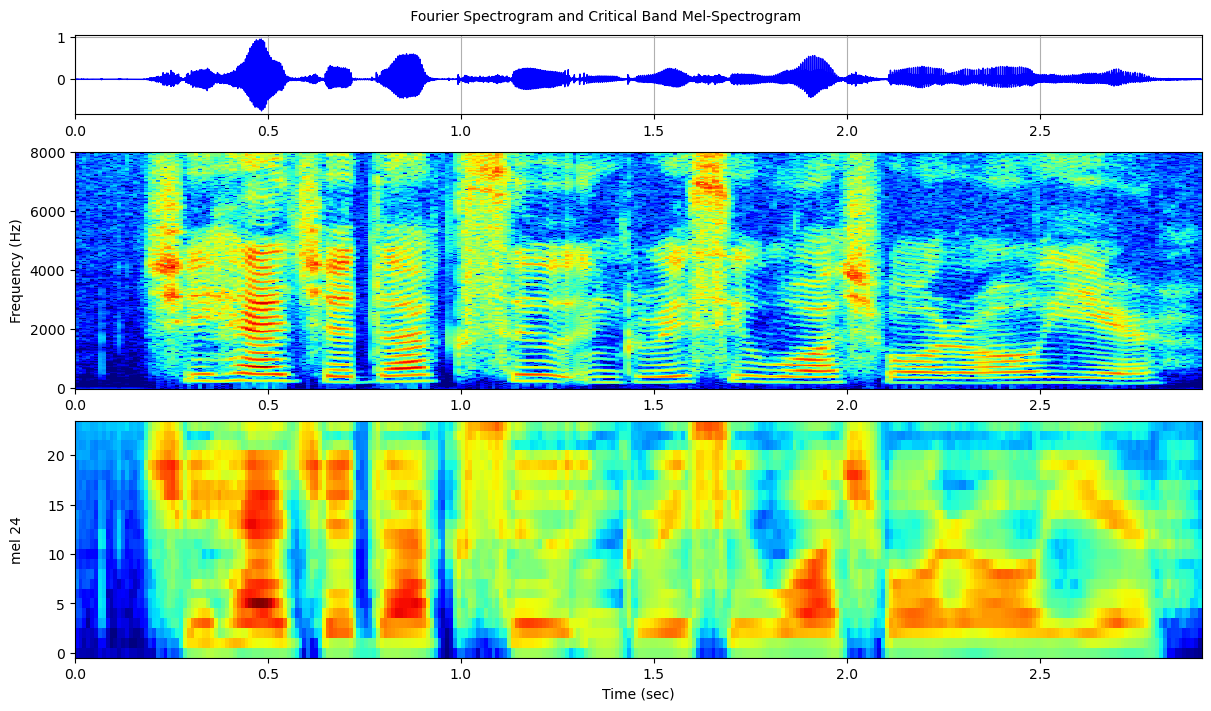

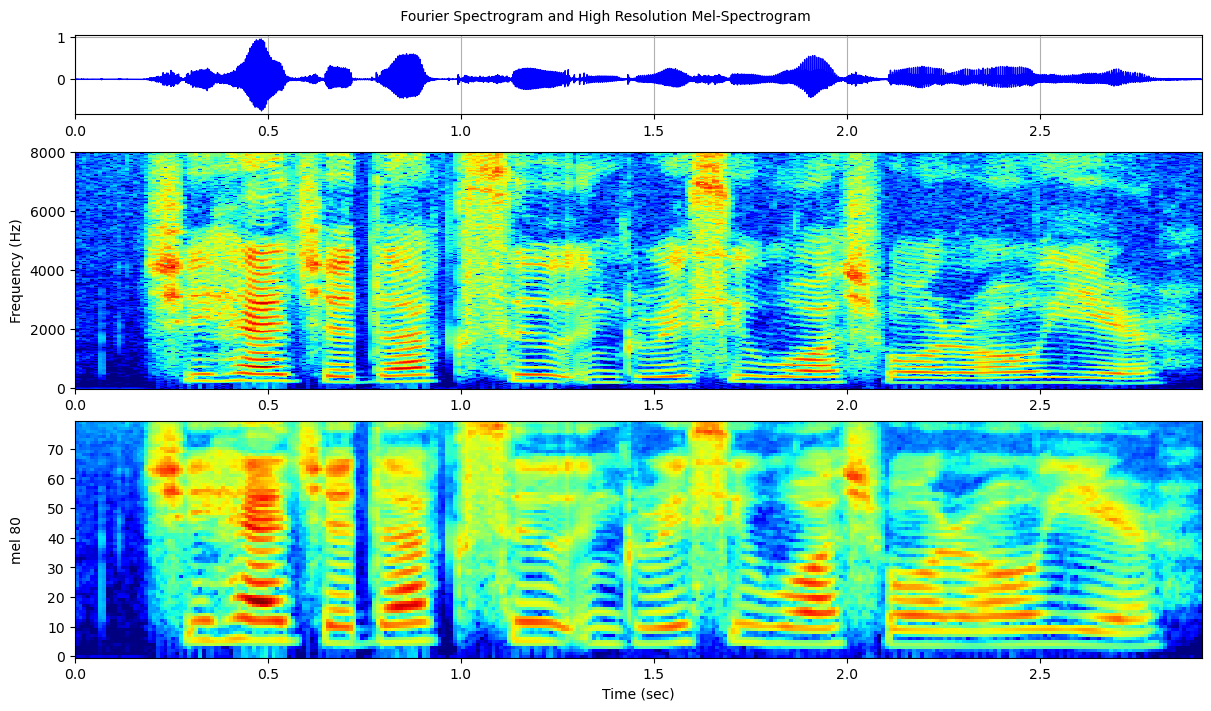

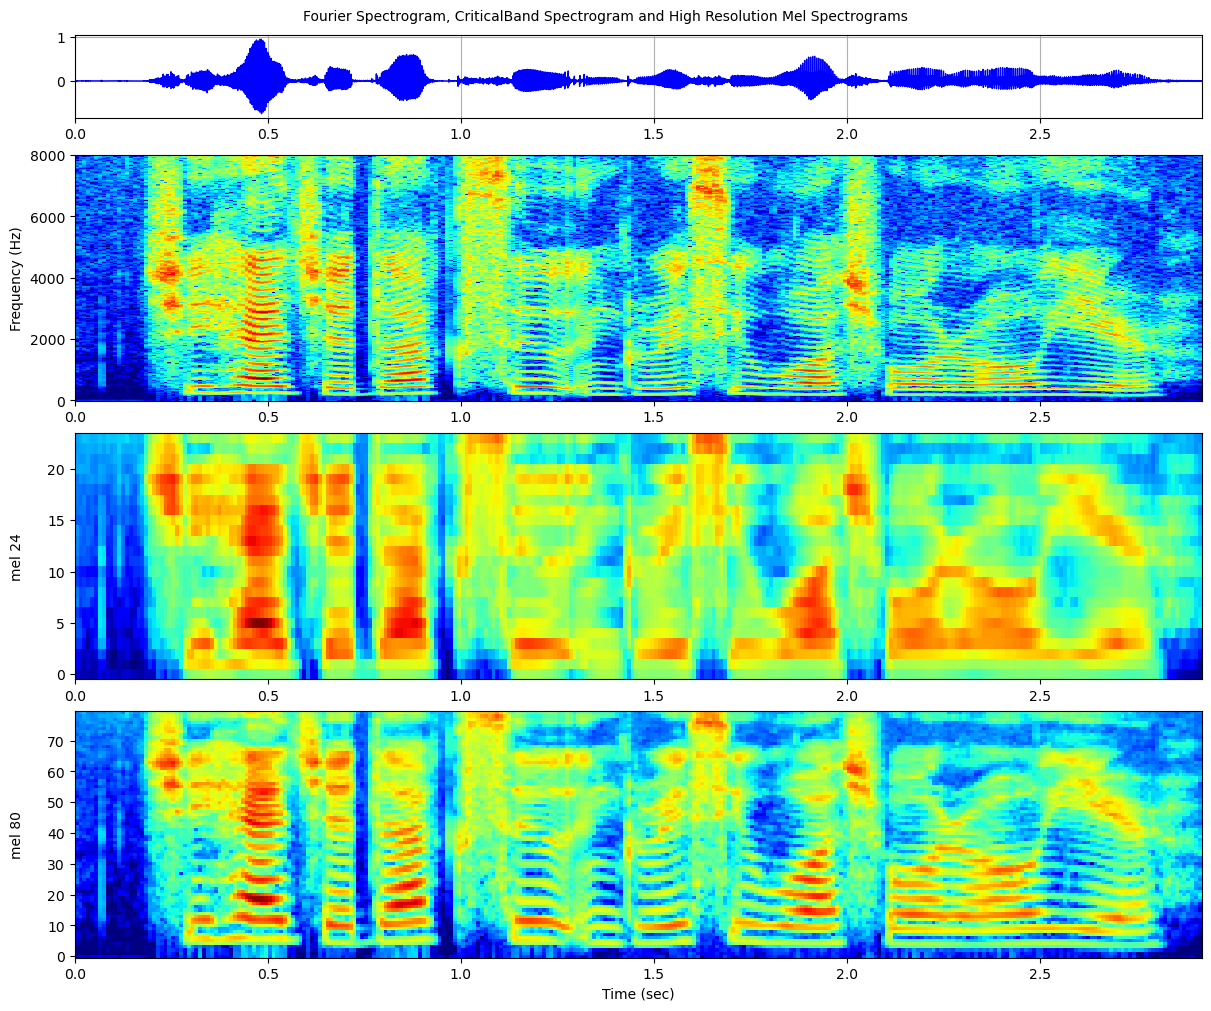

In [6]:
# compute a low and high resolution mel spectrogram
nmels1 = 24 if sr>8000 else 20
nmels2 = 80 if sr>8000 else 64
melspg1 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=nmels1)
melspg2 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=nmels2)
label1 = "mel "+str(nmels1)
label2 = "mel "+str(nmels2)

fig1 = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[melspg1],img_labels=[label1],sample_rate=sr,figsize=(12,7))
fig1.suptitle(" Fourier Spectrogram and Critical Band Mel-Spectrogram ")
display(fig1)
fig2 = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[melspg2],img_labels=[label2],sample_rate=sr,figsize=(12,7))
fig2.suptitle(" Fourier Spectrogram and High Resolution Mel-Spectrogram ")
display(fig2)
fig3 = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[melspg1,melspg2],img_labels=[label1,label2],sample_rate=sr,figsize=(12,10))
fig3.suptitle("Fourier Spectrogram, CriticalBand Spectrogram and High Resolution Mel Spectrograms")
display(fig3)
if SAVE_FIG : 
    fig1.savefig("figures/melspg1_"+name+".png")
    fig2.savefig("figures/melspg2_"+name+".png")
    fig3.savefig("figures/melspg3_"+name+".png")

## 4. GUI 2
Just observe some more mel spectra for different input files

In [8]:
### Define spectrogram plot ###
def spectrogram_plot(n_mels=24,file="misc/friendly.wav",root=None):
    wavfile = file
    wavdata, sr = Spch.load_data(wavfile,root=root)
    spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
    spg_mel = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=n_mels)
    fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[spg_mel],img_labels=["MEL "+str(n_mels)],sample_rate=sr,figsize=(12,7))
    display(fig,Audio(data=wavdata,rate=sr))

### GUI #####################
#############################
file_options = ["demo/friendly.wav","demo/d15zz6.wav","demo/timit_f1_sa1.wav", "demo/timit_m1_sa1.wav","demo/female1.wav"]
wg_file = widgets.Dropdown(options=file_options,value=file_options[0],description="File Name")
wg_mels=widgets.IntSlider(value=24,min=4,max=128,step=4,
                            continous_update=False,description="n_mels",orientation = 'horizontal')
output = widgets.interactive_output(spectrogram_plot,{'n_mels':wg_mels,'file':wg_file})
 
wg_instructions = widgets.HTML(
    "<b>MEL SPECTROGRAM</b><br> \
    Move the n_mels Slider to control the number of filters to be used in the Mel Filterbank<br>\
    Check the 'mel'-box to work with mel-spectrograms")

ui = VBox([ wg_instructions, VBox([wg_file,wg_mels],layout=Spd.box_layout(width='100%',border='',align_items='flex-start'))],
          layout=Spd.box_layout(width='100%',padding='10px'))

In [9]:
# Run the GUI
display(VBox([ui, output]))

### Some Questions

+ How does the regular (Fourier) spectrogram compare with the mel spectrogram ?
    - think about psychoacoustics, source-filter model, ...
+ How does the mel spectrogram change visualy when you reduce the number of mel filterbanks from 80 to 24 or even to less than 10  ?
+ What seems the be the benefit of the mel spectrogram vs. a Fourier spectrogram
+ Are your responses dependent on the input sample (male vs female, 8kHz vs. 16kHz sampling rate, ... ) ?
+ Find the tuning frequency of the middle channel of a filterbank 
    + is this frequency equal, lower or higher than the halfway point of the frequency axis in a Fourier spectrogram (i.e. sampling_rate/4 ?  
    + is the answer dependent on the choice for critical bands or high resolution ?